<a href="https://colab.research.google.com/github/MartinaWestrik/Eurosat-Neural-Networks/blob/Vlastni-model_sjednocena_priprava_dat/DATA_proof_V0_z_V1_VGG16_Eurosat_s_augmentaci_4vrstvy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#INFO O PROJEKTU
**C√≠lem** projektu je vytr√©nov√°n√≠ modelu, kter√Ω na z√°kladƒõ anal√Ωzy datasetu 27000 satelitn√≠ch sn√≠mk≈Ø ze za≈ô√≠zen√≠ Sentinel2 rozpozn√°v√° 10 druh≈Ø t≈ô√≠d land use - vyu≈æit√≠ p≈Ødy, nap≈ô. pole, pastvina, d√°lnice, jezera, ≈ôeky, zastavƒõn√© √∫zem√≠, pr≈Ømyslov√° z√≥na apod. Sn√≠mky maj√≠ po √∫pravƒõ ze 13 spektr√°ln√≠ho nastaven√≠ (EuroSATallBands, *tif) pouze t≈ô√≠barven√© kan√°ly (RGB), rozmƒõry 64x64 pixel≈Ø (EuroSAT, *.jpg) Projekt jsme si vybrali na https://www.kaggle.com/datasets/apollo2506/eurosat-dataset, k sestavov√°n√≠ modelu jsme vyu≈æili zdej≈°√≠ kody, chatgpt, vzorov√Ω p≈ô√≠klad na Colab - ≈°achy.

**Postup**

Postaven√≠ vlastn√≠ho modelu neuronov√© s√≠tƒõ a ladƒõn√≠ parametr≈Ø (V0)

Pou≈æit√≠ p≈ôedtr√©novan√©ho modelu VGG16 (V1) a XXX (V2) pro efektivnƒõj≈°√≠ tr√©nov√°n√≠.

Vyhodnocen√≠ model≈Ø pomoc√≠ p≈ôesnosti a konfuzn√≠ matice.

#NAƒåTEN√ç KNIHOVEN

In [ ]:
# Importy
import os
import random

import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt  # Vizualizace
import seaborn as sns  # Matice z√°mƒõn
from sklearn.metrics import confusion_matrix, classification_report  # Klasifikaƒçn√≠ metriky

import kagglehub
from google.colab import files

#NAƒåTEN√ç DAT

In [ ]:
# Download latest version
path = kagglehub.dataset_download("apollo2506/eurosat-dataset")

print("Path to dataset files:", path)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2.04G/2.04G [00:26<00:00, 84.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/apollo2506/eurosat-dataset/versions/6


In [ ]:
# 1. Nastaven√≠ spr√°vn√© cesty ke slo≈æce s obr√°zky
DATASET_PATH = "/root/.cache/kagglehub/datasets/apollo2506/eurosat-dataset/versions/6"
print("Dataset obsahuje:", os.listdir(DATASET_PATH))

Dataset obsahuje: ['EuroSAT', 'EuroSATallBands']


In [ ]:
# 2. Cesta ke slo≈æk√°m s obr√°zky
data_dir = os.path.join(DATASET_PATH, "EuroSAT")

# 3. Parametry datasetu
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
NUM_CLASSES = 10

In [ ]:
# 4. Naƒçten√≠ datasetu a p≈ô√≠prava dat pomoc√≠ ImageDataGenerator a augemtnac√≠

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,         # m√≠rn√° rotace ‚Äì satelitn√≠ √∫hly se mohou li≈°it
    zoom_range=0.1,            # m√≠rn√© p≈ôibl√≠≈æen√≠/odd√°len√≠
    horizontal_flip=True,      # satelitn√≠ z√°bƒõry jsou symetrick√© ‚Äì horizont√°ln√≠ flip d√°v√° smysl
    fill_mode='nearest',
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    shuffle=True,             # l√©pe pro uƒçen√≠
    target_size=(128,128),    #ZVETSENI OBRAZKU Z GENERATORU
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)
val_generator = train_datagen.flow_from_directory(
    data_dir,
    shuffle=False,            # zachovat pro spr√°vn√© vyhodnocen√≠
    target_size=(128,128),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


#VLASTN√ç MODEL

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

In [ ]:
# vytvo≈ôen√≠  vlastn√≠ho modelu, ; Sequentional= ka≈æd√° vrstva p≈ôid√°v√° novou transformaci dat, kter√° zlep≈°uje schopnost modelu rozpozn√°vat vzory
model = Sequential([
    # prvn√≠ konvoluƒçn√≠ vrstva
    Input(shape=(128,128, 3)),
    Conv2D(32, (3,3), activation='relu'),                         #32 filtr≈Ø hled√° jin√© vzory v matrici 3x3 pixely, "relu"p≈ôev√°d√≠ z√°porn√© hodnoty aktivaƒçn√≠ funkce na nulu, model oƒçek√°v√° obr√°zky RGB 64x64
    MaxPooling2D(2,2),                                             # pooling sni≈æuje velikost obr√°zk≈Ø (na polovinu = 32x32) => sni≈æuje rozsah v√Ωpoƒçtu a vyb√≠r√° ty nejd≈Øle≈æitƒõj≈°√≠ tvary na obr√°zku

    # druh√° konvoluƒçn√≠ vrstva
    Conv2D(64, (3,3), activation='relu'),                          #64 filtr≈Ø analyzuje slo≈æitƒõj≈°√≠ tvary,
    MaxPooling2D(2,2),                                              # sni≈æuje velikost obr√°zku na 16x16

    # t≈ôet√≠ konvoluƒçn√≠ vrstva
    Conv2D(128, (3,3), activation='relu'), #nasazuje 128 filtr≈Ø     #stabilizuje v√Ωstupy z neuron≈Ø
    MaxPooling2D(2,2),                                               #sni≈æuje velikost obr√°zku na 8x8

    # ƒçtvrt√° konvoluƒçn√≠ vrstva
    Conv2D(128, (3,3), activation='relu'), #nasazuje 128 filtr≈Ø     #stabilizuje v√Ωstupy z neuron≈Ø
    MaxPooling2D(2,2),                                               #sni≈æuje velikost obr√°zku na 8x8

    # zplo≈°tƒõn√≠ p≈ôevede data z 8x8x256 => m√°me vektor s 16 384 prvky, kter√© mohou vstoupit do dense vrstvy se 256 neurony  a
    Flatten(),

    #DOPLNƒöN√ç DENSE vrstvy pro V√çCE PARAMETR≈Æ TR√âNOV√ÅN√ç
    Dense(512, activation='relu'),
    Dropout(0.4),

    # .... do dense vsrtvy se 256 neurony a p≈ôirpavit se na klasifikaci
    Dense(256, activation='relu'),
    Dropout(0.3),                                                # v dense vrstvƒõ "vypne" 30% neuron≈Ø, br√°n√≠ t√≠m p≈ôeuƒçen√≠

    # v√Ωstupn√≠ vrstva s 10 t≈ô√≠dami (softmax pro klasifikaci)
    Dense(10, activation='softmax')
])

In [ ]:
# 9. Kompilace modelu
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
# 10. V√Ωpis struktury modelu
model.summary()

Model: "sequential_2"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ conv2d_8 (Conv2D)                    ‚îÇ (None, 126, 126, 32)        ‚îÇ             896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_8 (MaxPooling2D)       ‚îÇ (None, 63, 63, 32)          ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_9 (Conv2D)                    ‚îÇ (None, 61, 61, 64)          ‚îÇ          18,496 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_9 (MaxPooling2D)       ‚îÇ (None, 30, 30, 64)          ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_10 (Conv2D)                   ‚îÇ (None, 28, 28, 128)         ‚îÇ          73,856 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_10 (MaxPooling2D)      ‚îÇ (None, 14, 14, 128)         ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_11 (Conv2D)                   ‚îÇ (None, 12, 12, 128)         ‚îÇ         147,584 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_11 (MaxPooling2D)      ‚îÇ (None, 6, 6, 128)           ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten_2 (Flatten)                  ‚îÇ (None, 4608)                ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_6 (Dense)                      ‚îÇ (None, 512)                 ‚îÇ       2,359,808 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

 Total params: 2,734,538 (10.43 MB)

 Trainable params: 2,734,538 (10.43 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 11. Definov√°n√≠ EarlyStopping callbacku
early_stopping = EarlyStopping(
    monitor="val_loss",   # Sledujeme validaƒçn√≠ ztr√°tu
    patience=3,           # Po 3 epoch√°ch bez zlep≈°en√≠ ukonƒç√≠ tr√©nov√°n√≠
    restore_best_weights=True # Vr√°t√≠ nejlep≈°√≠ model
)

In [ ]:
# 12. Definov√°n√≠ callbacku pro ukl√°d√°n√≠ nejlep≈°√≠ho modelu
checkpoint = ModelCheckpoint(
    filepath="best_model.keras",  # Ulo≈æen√≠ modelu do souboru
    monitor="val_accuracy",       # Sleduje nejlep≈°√≠ p≈ôesnost na validaƒçn√≠ch datech
    save_best_only=True,          # Ulo≈æ√≠ pouze nejlep≈°√≠ model
    save_weights_only=False,      # Ulo≈æ√≠ model vƒçetnƒõ architektury (ne jen v√°hy)
    verbose=1                     # Zobraz√≠ info o ukl√°d√°n√≠
)

In [ ]:
# 13. Tr√©nov√°n√≠ modelu
EPOCHS = 100
history = model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator,verbose=1, callbacks=[early_stopping, checkpoint])

Epoch 1/100
675/675 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1s/step - accuracy: 0.2674 - loss: 1.8573
Epoch 1: val_accuracy improved from -inf to 0.57944, saving model to best_model.keras
675/675 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 940s 1s/step - accuracy: 0.2676 - loss: 1.8569 - val_accuracy: 0.5794 - val_loss: 1.1596
Epoch 2/100
675/675 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1s/step - accuracy: 0.5405 - loss: 1.2062
Epoch 2: val_accuracy improved from 0.57944 to 0.68148, saving model to best_model.keras
675/675 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 971s 1s/step - accuracy: 0.5405 - loss: 1.2061 - val_accuracy: 0.6815 - val_loss: 0.8743
Epoch 3/100
675/675 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 1s/step - accuracy: 0.6474 - loss: 0.9824
Epoch 3: val_accuracy improved from 0.68148 to 0.72333, saving model to best_model.keras
675/675 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

In [ ]:
# 14. Vyhodnocen√≠ modelu na validaƒçn√≠ sadƒõ
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validaƒçn√≠ p≈ôesnost: {val_acc:.4f}")

169/169 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 70s 411ms/step - accuracy: 0.8457 - loss: 0.4412
Validaƒçn√≠ p≈ôesnost: 0.8470


In [ ]:
# 15. Funkce pro predikci TOP-2 t≈ô√≠d u nov√©ho obr√°zku
def predict_top_2(image_path, model, class_indices):
    from tensorflow.keras.preprocessing import image

    img = image.load_img(image_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)[0]

    top_2_indices = np.argsort(predictions)[-2:][::-1]
    top_2_classes = [list(class_indices.keys())[list(class_indices.values()).index(i)] for i in top_2_indices]
    top_2_probs = [predictions[i] for i in top_2_indices]

    return list(zip(top_2_classes, top_2_probs))

In [ ]:
# 16. Z√≠sk√°n√≠ jmen t≈ô√≠d
class_indices = train_generator.class_indices

In [ ]:
# 17. Test predikce na n√°hodn√©m obr√°zku z datasetu
random_image = random.choice(train_generator.filepaths)

top_2_predictions = predict_top_2(random_image, model, class_indices)
print(f"Top-2 predikovan√© t≈ô√≠dy pro obr√°zek: {top_2_predictions}")

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_6" is incompatible with the layer: expected axis -1 of input shape to have value 4608, but received input with shape (1, 512)[0m

Arguments received by Sequential.call():
  ‚Ä¢ inputs=tf.Tensor(shape=(1, 64, 64, 3), dtype=float32)
  ‚Ä¢ training=False
  ‚Ä¢ mask=None

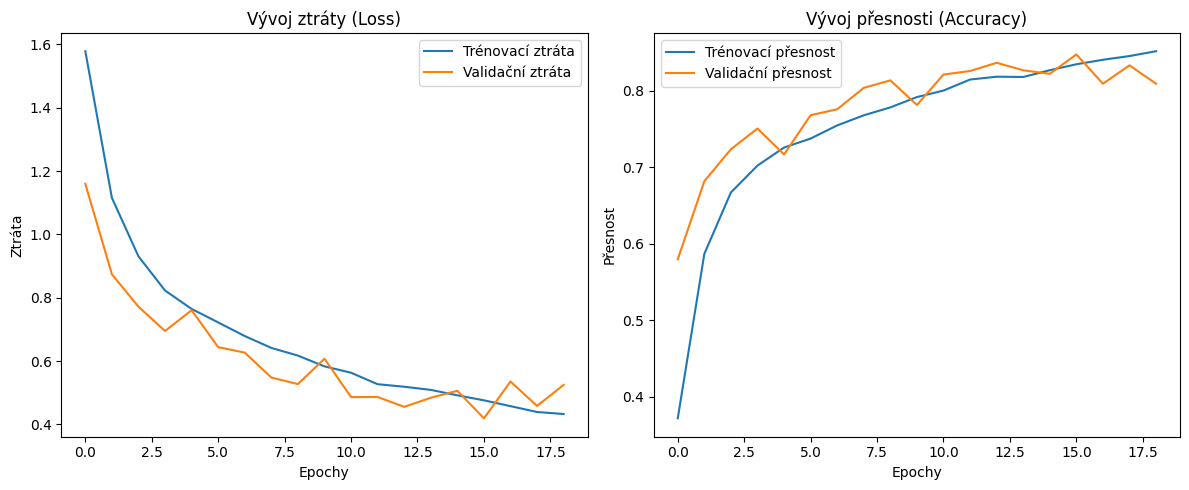

In [ ]:
# 18. Vizualizace tr√©nov√°n√≠ ‚Äì Graf p≈ôesnosti a ztr√°ty
def plot_training_history(history):
    import matplotlib.pyplot as plt  # pro jistotu, pokud nen√≠ u≈æ importov√°no
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Graf ztr√°ty (Loss)
    axs[0].plot(history.history['loss'], label='Tr√©novac√≠ ztr√°ta')
    axs[0].plot(history.history['val_loss'], label='Validaƒçn√≠ ztr√°ta')
    axs[0].set_title('V√Ωvoj ztr√°ty (Loss)')
    axs[0].set_xlabel('Epochy')
    axs[0].set_ylabel('Ztr√°ta')
    axs[0].legend()

    # Graf p≈ôesnosti (Accuracy)
    axs[1].plot(history.history['accuracy'], label='Tr√©novac√≠ p≈ôesnost')
    axs[1].plot(history.history['val_accuracy'], label='Validaƒçn√≠ p≈ôesnost')
    axs[1].set_title('V√Ωvoj p≈ôesnosti (Accuracy)')
    axs[1].set_xlabel('Epochy')
    axs[1].set_ylabel('P≈ôesnost')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# ‚úÖ Teƒè zavol√°≈° funkci mimo jej√≠ tƒõlo:
plot_training_history(history)

169/169 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 71s 416ms/step


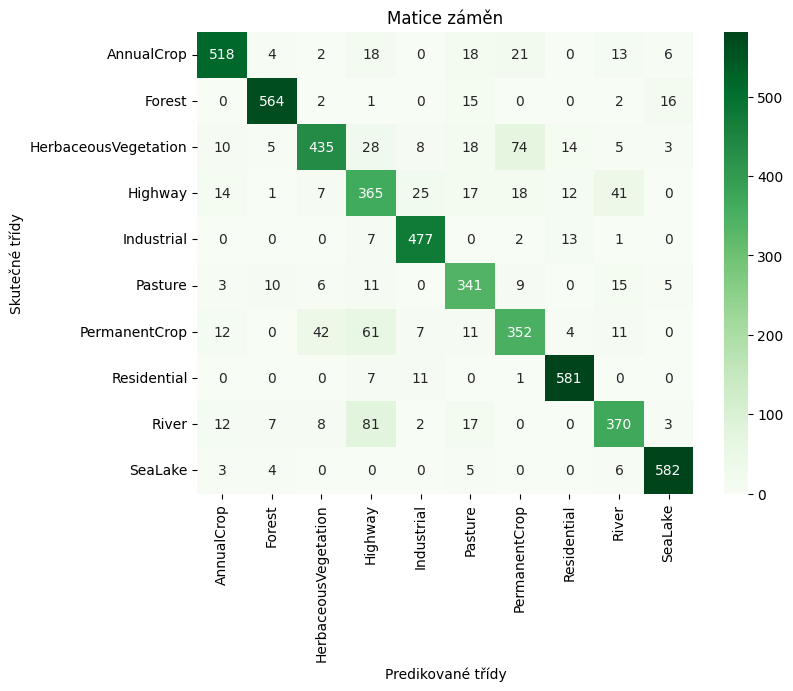


Klasifikaƒçn√≠ report:
                      precision    recall  f1-score   support

          AnnualCrop       0.91      0.86      0.88       600
              Forest       0.95      0.94      0.94       600
HerbaceousVegetation       0.87      0.72      0.79       600
             Highway       0.63      0.73      0.68       500
          Industrial       0.90      0.95      0.93       500
             Pasture       0.77      0.85      0.81       400
       PermanentCrop       0.74      0.70      0.72       500
         Residential       0.93      0.97      0.95       600
               River       0.80      0.74      0.77       500
             SeaLake       0.95      0.97      0.96       600

            accuracy                           0.85      5400
           macro avg       0.84      0.84      0.84      5400
        weighted avg       0.85      0.85      0.85      5400



In [ ]:
# Z√≠sk√°n√≠ skuteƒçn√Ωch a predikovan√Ωch hodnot
y_true = val_generator.classes  # Skuteƒçn√© t≈ô√≠dy
y_pred_probs = model.predict(val_generator)  # Predikovan√© pravdƒõpodobnosti
y_pred = y_pred_probs.argmax(axis=1)  # Nejpravdƒõpodobnƒõj≈°√≠ t≈ô√≠dy

# Matice z√°mƒõn
cm = confusion_matrix(y_true, y_pred)
labels = list(val_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predikovan√© t≈ô√≠dy")
plt.ylabel("Skuteƒçn√© t≈ô√≠dy")
plt.title("Matice z√°mƒõn")
plt.show()

# V√Ωpis klasifikaƒçn√≠ zpr√°vy
print("\nKlasifikaƒçn√≠ report:")
print(classification_report(y_true, y_pred, target_names=labels))

#Vizualizace z√°mƒõn


In [ ]:
# Z√≠sk√°me nejƒçastƒõj≈°√≠ chybnou z√°mƒõnu (ignorujeme diagon√°lu = spr√°vn√© predikce)
cm_copy = cm.copy()
np.fill_diagonal(cm_copy, 0)  # odstran√≠me spr√°vn√© klasifikace
max_confusion = np.unravel_index(np.argmax(cm_copy), cm_copy.shape)

true_class_idx, pred_class_idx = max_confusion
true_class = labels[true_class_idx]
pred_class = labels[pred_class_idx]

print(f"üîç Nejƒçastƒõj≈°√≠ z√°mƒõna: Skuteƒçn√° t≈ô√≠da = '{true_class}', Predikovan√° = '{pred_class}'")

üîç Nejƒçastƒõj≈°√≠ z√°mƒõna: Skuteƒçn√° t≈ô√≠da = 'River', Predikovan√° = 'Highway'


In [ ]:
 #P≈ôevedeme generator do DataFrame (pokud m√°≈° flow_from_dataframe, pou≈æij p≈ô√≠mo val_df)
 import pandas as pd
val_filenames = val_generator.filenames  # cesty k obr√°zk≈Øm
df_val = pd.DataFrame({
    "filename": val_filenames,
    "true_label": y_true,
    "pred_label": y_pred
})

# Vybereme p≈ô√≠klady, kde do≈°lo ke konkr√©tn√≠ z√°mƒõnƒõ
mistakes = df_val[(df_val["true_label"] == true_class_idx) & (df_val["pred_label"] == pred_class_idx)]

<ipython-input-36-80aa9fc4b5fc>:17: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


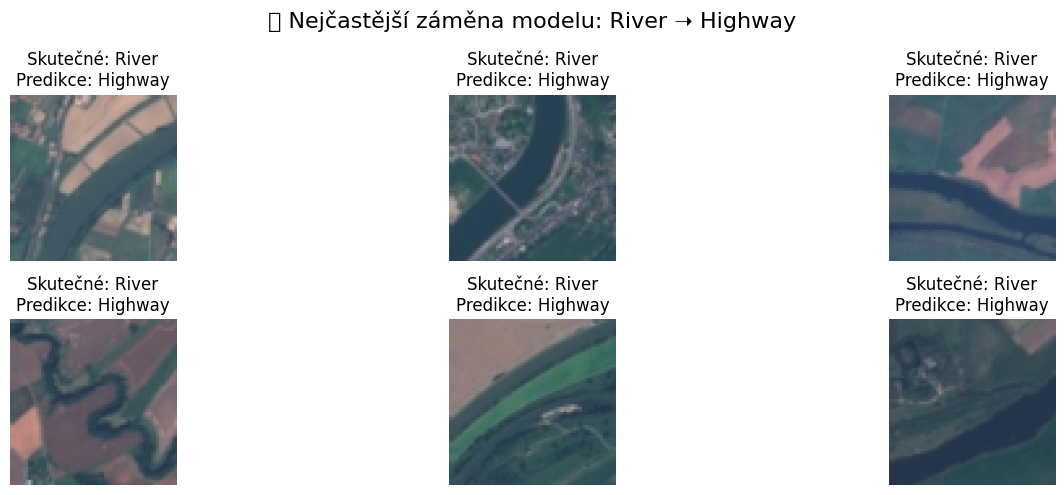

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Zobraz√≠me max 5 chybn√Ωch obr√°zk≈Ø
sample_mistakes = mistakes.sample(n=min(6, len(mistakes)))

plt.figure(figsize=(15, 5))
for i, row in enumerate(sample_mistakes.itertuples()):
    img_path = os.path.join(val_generator.directory, row.filename)
    img = load_img(img_path, target_size=(128, 128))  # p≈ôizp≈Øsob target_size

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Skuteƒçn√©: {true_class}\nPredikce: {pred_class}")

plt.suptitle(f"üîç Nejƒçastƒõj≈°√≠ z√°mƒõna modelu: {true_class} ‚ûù {pred_class}", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# St√°hnut√≠ modelu do poƒç√≠taƒçe
files.download("best_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>